Data generated using `"$FAIRSHIP"/macro/run_simScript.py --Pythia8 -n 10000 --couplings '0,1e-8,0' --mass '1.5'`

For this test, interactions with the detector were disabled using the `exclusionList` in `shipDet_conf.py`.

In [1]:
const std::string dirname("./2017-05-28/before"); // Replace by /path/to/data/directory
const std::string filename("ship.conical.Pythia8-TGeant4.root");
const auto fullname = dirname + "/" + filename;

In [2]:
TFile dat(fullname.c_str(), "read");

In [3]:
auto tree = dynamic_cast<TTree*>(dat.Get("cbmsim"));

In [4]:
TTreeReader reader(tree);

In [5]:
TTreeReaderArray<Int_t> code(reader, "MCTrack.fPdgCode");

In [6]:
TTreeReaderArray<Double32_t> Px(reader, "MCTrack.fPx");
TTreeReaderArray<Double32_t> Py(reader, "MCTrack.fPy");
TTreeReaderArray<Double32_t> Pz(reader, "MCTrack.fPz");
TTreeReaderArray<Double32_t> M(reader, "MCTrack.fM");
TTreeReaderArray<Int_t> motherId(reader, "MCTrack.fMotherId");

In [7]:
constexpr Int_t hnlCode = 9900015;

In [8]:
TH1F histInvM("histInvM", "HNL mass (reconstructed from decay products)", 100, 0, 2);

In [9]:
TH1F histHNLMass("histHNLMass", "HNL mass (as recorded)", 100, 0, 2);

In [10]:
std::vector<UInt_t> hnlIds;
Double_t hnlMinMass(std::numeric_limits<double>::infinity()), hnlMaxMass(-std::numeric_limits<double>::infinity());
while (reader.Next()) {
    hnlIds.resize(0);
    const UInt_t sz = code.GetSize();
    assert(Pz.GetSize() == sz);
    assert(motherId.GetSize() == sz);
    // Find HNLs and fill the histogram of recorded mass
    for (UInt_t i = 0; i < sz; ++i) {
        if (code[i] == hnlCode) {
            hnlIds.push_back(i);
            histHNLMass.Fill(M[i]);
            hnlMinMass = std::min(hnlMinMass, M[i]);
            hnlMaxMass = std::max(hnlMaxMass, M[i]);
        }
    }
    // Recompute the HNL mass from the 4-momenta of their decay products
    for (UInt_t i = 0; i < hnlIds.size(); ++i) {
        const auto id = hnlIds[i];
        assert(code[id] == hnlCode);
        Double32_t P[4] = {0.,0.,0.,0.};
        for (UInt_t j = 0; j < sz; ++j) {
            if (motherId[j] == id) {
                const Double32_t E = TMath::Sqrt(M[j]*M[j]+Px[j]*Px[j]+Py[j]*Py[j]+Pz[j]*Pz[j]);
                P[0] += E;
                P[1] += Px[j];
                P[2] += Py[j];
                P[3] += Pz[j];
            }
        }
        const Double32_t MInv = TMath::Sqrt(P[0]*P[0]-P[1]*P[1]-P[2]*P[2]-P[3]*P[3]);
        histInvM.Fill(MInv);
    }
}

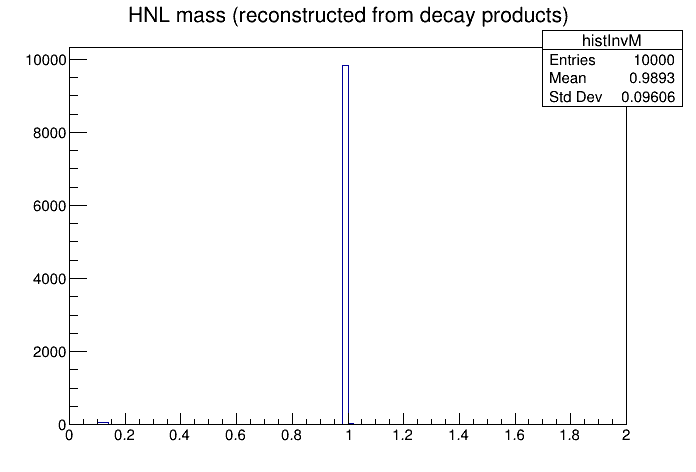

In [11]:
TCanvas c1;
histInvM.Draw();
c1.Draw();

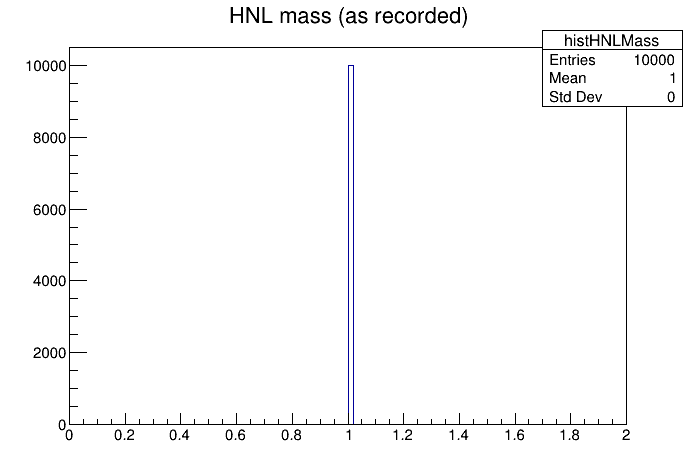

In [12]:
TCanvas c2;
histHNLMass.Draw();
c2.Draw();

In [13]:
std::cout << "HNL mass range: [" << hnlMinMass << ", " << hnlMaxMass << "] GeV" << std::endl;

HNL mass range: [1, 1] GeV
